<a href="https://colab.research.google.com/github/cdario79/FiltroFakeNews/blob/main/Filtro_per_Fake_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Filtro per Fake News
Il problema delle fake news è cresciuto esponenzialmente nell'ultimo decennio a causa della crescente diffusione dei social network, il governo degli Stati Uniti ha deciso di muoversi a tal proposito, incaricando la tua azienda di realizzare un plug-in per chrome in grado di riconoscere se una notizia è falsa. Il tuo compito è quello di realizzare il modello in grado di riconoscere le notizie false, che poi il team di machine learning enginner e web developer metterà in produzione. Ti vengono messi a disposizioni due raccolte di notizie, una contenente solo notizie false e l'altra contenente solo notizie vere, utilizzale per addestrare il tuo modello.

### [Link al dataset](https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip)

Parti da un'accurata analisi, rispondendo a domande come:
- le fake news sono più frequenti in una determinata categoria?
- per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?
- I titoli delle fake news presentano dei pattern?

Una volta addestrato il modello esportalo [utilizzando pickle](https://scikit-learn.org/stable/model_persistence.html) così che i tuoi colleghi possano metterlo in produzione.

## IMPORTAZIONE LIBRERIE UTILIZZATE

In [1]:
# Text Processing Libraries
import re  # For regular expression operations
import os  # For operating system interfaces
import requests  # For making HTTP requests
from dateutil import parser  # For parsing dates

# Data Manipulation and Analysis
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations

# Data Visualization
import matplotlib.pyplot as plt  # For plotting graphs
import seaborn as sns

# Machine Learning
import pickle  # For saving and loading the trained model
from sklearn.model_selection import train_test_split  # For splitting the dataset
from sklearn.feature_extraction.text import TfidfVectorizer  # For converting text to vectors
from sklearn.svm import SVC  # For Support Vector Classification
from sklearn.metrics import classification_report  # For generating classification reports

# Natural Language Processing
import nltk  # For Natural Language Processing
from nltk.tokenize import word_tokenize  # For tokenization
from nltk.tag import pos_tag  # For part-of-speech tagging
from nltk.chunk import ne_chunk  # For named entity recognition
from collections import Counter  # For counting occurrences
from nltk.corpus import stopwords  # For stop words

# Download NLTK data required for tokenization, part-of-speech tagging,
# named entity recognition, and named entities
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')

# Advanced Language Processing
import spacy  # For advanced language processing
from spacy.lang.en.stop_words import STOP_WORDS as english_stopwords  # For English stopwords from Spacy

# Load the Spacy model
nlp = spacy.load("en_core_web_sm")  # Load the Spacy model for English

# Gensim for Topic Modeling
import gensim
from gensim import corpora  # For handling corpora of text documents
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint  # For pretty-printing

# Word Cloud
from wordcloud import WordCloud  # For generating word clouds

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## FUNZIONI UTILIZZATE

In [2]:
def download_csv_from_google_drive(file_id):
    """
    Downloads a CSV file from Google Drive given the file_id.

    Args:
        file_id (str): The unique identifier for the Google Drive file.

    Returns:
        str: The absolute path to the downloaded file.
    """

    def get_confirm_token(response):
        """
        Retrieves the confirmation token from the response cookies if present.

        Args:
            response (requests.Response): The response object from the initial request.

        Returns:
            str: The confirmation token if found, otherwise None.
        """
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value
        return None

    def save_response_content(response, destination):
        """
        Saves the content of the response to a file in chunks.

        Args:
            response (requests.Response): The response object containing the file data.
            destination (str): The destination path where the file will be saved.
        """
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk:  # Filter out keep-alive new chunks
                    f.write(chunk)

    def download_file_from_google_drive(file_id, destination):
        """
        Handles the download process from Google Drive, managing potential confirmation tokens.

        Args:
            file_id (str): The unique identifier for the Google Drive file.
            destination (str): The destination path where the file will be saved.
        """
        URL = "https://drive.google.com/uc?export=download"
        session = requests.Session()

        response = session.get(URL, params={'id': file_id}, stream=True)
        token = get_confirm_token(response)

        if token:
            params = {'id': file_id, 'confirm': token}
            response = session.get(URL, params=params, stream=True)

        save_response_content(response, destination)

    file_name = f"{file_id}.csv"

    if not os.path.exists(file_name):
        print(f"File {file_name} non trovato. Scaricamento in corso ...")
        download_file_from_google_drive(file_id, file_name)
        print(f"File {file_name} scaricato correttamente.")
    else:
        print(f"File {file_name} già presente.")

    return os.path.abspath(file_name)

## CARICO E ANALIZZO LE NOTIZIE VERE

In [3]:
ORIGINAL_TRUE_NEWS_DATA_FILE_GDRIVE_ID = '1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f'
original_true_news_csv_path = download_csv_from_google_drive(ORIGINAL_TRUE_NEWS_DATA_FILE_GDRIVE_ID)

File 1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f.csv non trovato. Scaricamento in corso ...
File 1Q77cWcaKM6XiOOE1_2cEjuCaLFJRwq2f.csv scaricato correttamente.


In [4]:
df_true = pd.read_csv(original_true_news_csv_path)
df_true.sample(10)

,title,text,subject,date
17415,UK PM May to travel to Brussels for meetings w...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"October 15, 2017"
16552,Factbox: Xi allies dominate China's new 25-mem...,(Reuters) - While the new seven-member Politbu...,worldnews,"October 25, 2017"
1959,Mattis signs orders to send additional troops ...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,politicsNews,"August 31, 2017"
20407,Pakistan PM warns U.S. sanctions would be coun...,ISLAMABAD (Reuters) - Pakistan s Prime Ministe...,worldnews,"September 11, 2017"
17358,Iraq warns Kurdistan not to shut down Kirkuk o...,BAGHDAD (Reuters) - Iraq said on Monday it was...,worldnews,"October 16, 2017"
21133,"Kenyan president, election overturned by court...",NAIROBI (Reuters) - Kenyan President Uhuru Ken...,worldnews,"September 2, 2017"
13750,"Water entered missing Argentine sub's snorkel,...",BUENOS AIRES (Reuters) - Water entered the sno...,worldnews,"November 27, 2017"
7241,Trump team weighs 'infrastructure bank' to fun...,NEW YORK (Reuters) - U.S. President-elect Dona...,politicsNews,"November 16, 2016"
17701,Ukraine's controversial law reforms open to re...,SYDNEY (Reuters) - Ukrainian Justice Minister ...,worldnews,"October 12, 2017"
7029,Wide-ranging U.S. health bill expected to sail...,(Reuters) - The U.S. House of Representatives ...,politicsNews,"November 29, 2016"


In [5]:
df_true.shape

(21417, 4)

In [6]:
# check null value
df_true.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [7]:
df_true.title[df_true.title.str.strip()==''].count()

0

In [8]:
# empty news
df_true.text[df_true.text.str.strip()==''].count()

1

In [9]:
# Trova le righe vuote nel DataFrame
true_text_empty_row = df_true[df_true['text'].str.strip() == '']

true_text_empty_row

,title,text,subject,date
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016"


In [10]:
df_true.duplicated().sum()

206

In [11]:
true_duplicated_rows = df_true[df_true.duplicated(keep=False)]
true_duplicated_rows

,title,text,subject,date
416,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017"
445,Senate tax bill stalls on deficit-focused 'tri...,WASHINGTON (Reuters) - The U.S. Senate on Thur...,politicsNews,"November 30, 2017"
762,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017"
778,Trump warns 'rogue regime' North Korea of grav...,BEIJING (Reuters) - U.S. President Donald Trum...,politicsNews,"November 8, 2017"
850,"Republicans unveil tax cut bill, but the hard ...",WASHINGTON (Reuters) - U.S. House of Represent...,politicsNews,"November 2, 2017"
...,...,...,...,...
21290,"Europeans, Africans agree renewed push to tack...",PARIS (Reuters) - Europe s big four continen...,worldnews,"August 28, 2017"
21345,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017"
21353,Thailand's ousted PM Yingluck has fled abroad:...,BANGKOK (Reuters) - Ousted Thai prime minister...,worldnews,"August 25, 2017"
21406,"U.S., North Korea clash at U.N. forum over nuc...",GENEVA (Reuters) - North Korea and the United ...,worldnews,"August 22, 2017"


## CARICO E ANALIZZO LE NOTIZIE FALSE

In [12]:
ORIGINAL_FAKE_NEWS_DATA_FILE_GDRIVE_ID = '1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m'
original_fake_news_csv_path = download_csv_from_google_drive(ORIGINAL_FAKE_NEWS_DATA_FILE_GDRIVE_ID)

File 1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m.csv non trovato. Scaricamento in corso ...
File 1T3Ght1PgfcqZTdoYTqi7HhxYvIp1SJ-m.csv scaricato correttamente.


In [13]:
df_fake = pd.read_csv(original_fake_news_csv_path)
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [14]:
df_fake.shape

(23481, 4)

In [15]:
# check null value
df_fake.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [16]:
df_fake.title[df_fake.title.str.strip()==''].count()

0

In [17]:
df_fake.text[df_fake.text.str.strip()==''].count()

630

In [18]:
# Trova le righe vuote nel DataFrame
fake_text_empty_row = df_fake[df_fake['text'].str.strip() == '']

fake_text_empty_row

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [19]:
df_fake.duplicated().sum()

3

In [20]:
fake_duplicated_rows = df_fake[df_fake.duplicated(keep=False)]
fake_duplicated_rows

,title,text,subject,date
9941,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017"
9942,HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...,No time to waste we've got to fight with eve...,politics,"Sep 9, 2017"
11445,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017"
11446,FORMER DEMOCRAT WARNS Young Americans: “Rioter...,"Who is silencing political speech, physically...",politics,"Mar 10, 2017"
14924,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015"
14925,[VIDEO] #BlackLivesMatter Terrorists Storm Dar...,They were probably just looking for a safe sp...,politics,"Nov 16, 2015"


## Le fake news sono più frequenti in una determinata categoria?

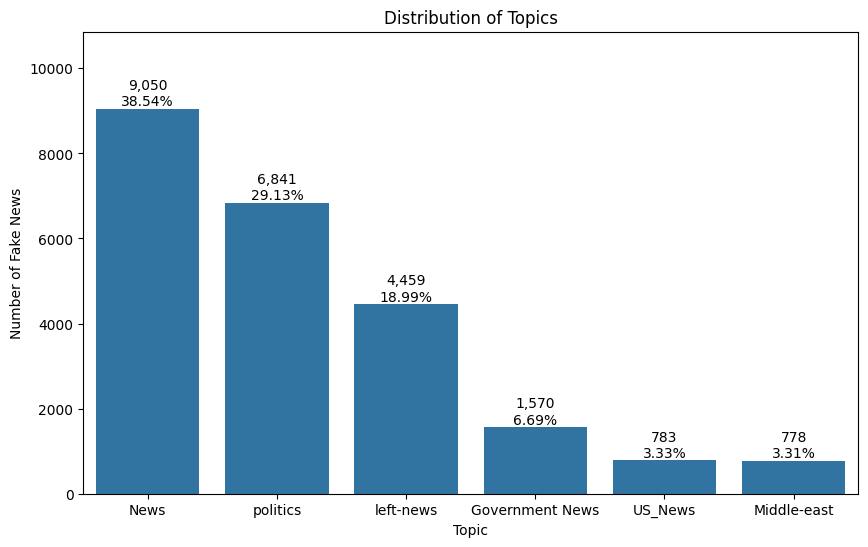

In [21]:
# Calcola il conteggio dei valori nel DataFrame
counts = df_fake['subject'].value_counts()

# Calcola la percentuale rispetto al totale
percentages = counts / counts.sum() * 100

# Ordina il conteggio dal più alto al più basso
counts_sorted = counts.sort_values(ascending=False)

# Crea il countplot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x=df_fake['subject'], order=counts_sorted.index)
#ax.bar_label(ax.containers[0])
for i, (index, count) in enumerate(counts_sorted.items()):
    plt.text(i, count + 70, f'{count:,.0f}\n{percentages[index]:,.2f}%', ha='center', color='black')


# Imposta il range dell'asse y
plt.ylim(0, counts.max() * 1.2)

plt.title('Distribution of Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Fake News')
plt.show()

## Per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?

LDA (Latent Dirichlet Allocation) è un modello di apprendimento automatico utilizzato per identificare argomenti nascosti all'interno di un insieme di documenti. Puoi utilizzare LDA per analizzare i testi degli articoli e identificare argomenti che potrebbero essere più soggetti alle fake news.

In [ ]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Load Dataset
data = df_fake.text.values.tolist()

# Tokenize words and cleanup the text
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations
data_words = list(sent_to_words(data))
print(data_words[:1])

[['donald', 'trump', 'just', 'couldn', 'wish', 'all', 'americans', 'happy', 'new', 'year', 'and', 'leave', 'it', 'at', 'that', 'instead', 'he', 'had', 'to', 'give', 'shout', 'out', 'to', 'his', 'enemies', 'haters', 'and', 'the', 'very', 'dishonest', 'fake', 'news', 'media', 'the', 'former', 'reality', 'show', 'star', 'had', 'just', 'one', 'job', 'to', 'do', 'and', 'he', 'couldn', 'do', 'it', 'as', 'our', 'country', 'rapidly', 'grows', 'stronger', 'and', 'smarter', 'want', 'to', 'wish', 'all', 'of', 'my', 'friends', 'supporters', 'enemies', 'haters', 'and', 'even', 'the', 'very', 'dishonest', 'fake', 'news', 'media', 'happy', 'and', 'healthy', 'new', 'year', 'president', 'angry', 'pants', 'tweeted', 'will', 'be', 'great', 'year', 'for', 'america', 'as', 'our', 'country', 'rapidly', 'grows', 'stronger', 'and', 'smarter', 'want', 'to', 'wish', 'all', 'of', 'my', 'friends', 'supporters', 'enemies', 'haters', 'and', 'even', 'the', 'very', 'dishonest', 'fake', 'news', 'media', 'happy', 'and'

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['donald', 'trump', 'just', 'couldn', 'wish', 'all', 'americans', 'happy', 'new', 'year', 'and', 'leave', 'it', 'at', 'that', 'instead', 'he', 'had', 'to', 'give', 'shout', 'out', 'to', 'his', 'enemies', 'haters', 'and', 'the', 'very', 'dishonest', 'fake', 'news', 'media', 'the', 'former', 'reality', 'show', 'star', 'had', 'just', 'one', 'job', 'to', 'do', 'and', 'he', 'couldn', 'do', 'it', 'as', 'our', 'country', 'rapidly', 'grows', 'stronger', 'and', 'smarter', 'want', 'to', 'wish', 'all', 'of', 'my', 'friends', 'supporters', 'enemies', 'haters', 'and', 'even', 'the', 'very', 'dishonest', 'fake', 'news', 'media', 'happy', 'and', 'healthy', 'new', 'year', 'president', 'angry', 'pants', 'tweeted', 'will', 'be', 'great', 'year', 'for', 'america', 'as', 'our', 'country', 'rapidly', 'grows', 'stronger', 'and', 'smarter', 'want', 'to', 'wish', 'all', 'of', 'my', 'friends', 'supporters', 'enemies', 'haters', 'and', 'even', 'the', 'very', 'dishonest', 'fake', 'news', 'media', 'happy', 'and',

In [ ]:
# Define function for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['wish', 'happy', 'new', 'year', 'leave', 'instead', 'give', 'shout', 'enemy', 'hater', 'dishonest', 'fake', 'news', 'medium', 'former', 'reality', 'show', 'star', 'job', 'country', 'rapidly', 'grow', 'strong', 'smart', 'want', 'wish', 'friend', 'supporter', 'enemy', 'hater', 'even', 'dishonest', 'fake', 'news', 'medium', 'happy', 'healthy', 'new', 'year', 'president', 'angry', 'pant', 'tweet', 'great', 'year', 'rapidly', 'grow', 'strong', 'smart', 'want', 'wish', 'friend', 'supporter', 'enemy', 'hater', 'even', 'dishonest', 'fake', 'news', 'medium', 'happy', 'healthy', 'new', 'year', 'great', 'year', 'realdonaldtrump', 'trump', 'tweet', 'go', 'welll', 'expect', 'kind', 'send', 'new', 'year', 'greeting', 'despicable', 'petty', 'infantile', 'gibberish', 'trump', 'lack', 'decency', 'even', 'allow', 'rise', 'gutter', 'long', 'enough', 'wish', 'american', 'citizen', 'happy', 'new', 'year', 'like', 'impeachment', 'make', 'great', 'year', 'also', 'accept', 'regain', 'hear', 'talk', 'include

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 3), (21, 1), (22, 5), (23, 1), (24, 1), (25, 3), (26, 1), (27, 3), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 3), (40, 1), (41, 2), (42, 1), (43, 1), (44, 6), (45, 1), (46, 6), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 2), (67, 3), (68, 1), (69, 11), (70, 3), (71, 3), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 2), (94, 1), (95, 2), (96, 2), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 7), (103, 3), (104, 2), (105, 1), (106, 2), (107, 1), (108, 1), (109, 5), (110, 1

In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.039*"report" + 0.029*"official" + 0.024*"russian" + 0.020*"source" + '
  '0.019*"case" + 0.018*"intelligence" + 0.017*"release" + 0.016*"information" '
  '+ 0.016*"state" + 0.016*"evidence"'),
 (1,
  '0.103*"crime" + 0.086*"charge" + 0.059*"authority" + 0.054*"arrest" + '
  '0.053*"criminal" + 0.049*"rubio" + 0.036*"nuclear" + 0.027*"trial" + '
  '0.025*"prison" + 0.024*"law_enforcement"'),
 (2,
  '0.276*"student" + 0.202*"school" + 0.080*"college" + 0.051*"parent" + '
  '0.045*"education" + 0.043*"station" + 0.036*"district" + '
  '0.034*"planned_parenthood" + 0.021*"high" + 0.020*"temporarily"'),
 (3,
  '0.414*"military" + 0.129*"protest" + 0.076*"player" + 0.039*"team" + '
  '0.023*"game" + 0.021*"existence" + 0.014*"celebration" + 0.013*"vet" + '
  '0.012*"bloody" + 0.012*"field"'),
 (4,
  '0.303*"woman" + 0.052*"female" + 0.051*"sex" + 0.051*"abortion" + '
  '0.050*"man" + 0.047*"rape" + 0.035*"apple" + 0.029*"sexual" + '
  '0.020*"county" + 0.020*"ballot"'),
 (5,
  '0.0

## Government Reports and Intelligence:
"report," "official," "russian," "intelligence," "source"

## Crime and Legal Actions:
"crime," "charge," "authority," "arrest," "criminal"

## Education and Schools:
"student," "school," "college," "parent," "education"

## Military and Protests:
"military," "protest," "player," "team," "game"

## Gender and Sexual Issues:
"woman," "female," "sex," "abortion," "rape"

## General News and Politics:
"year," "new," "state," "world," "political"

## Family and Personal Relationships:
"son," "mother," "evil," "daughter," "father"

## Legal and Judicial System:
"law," "court," "federal," "judge," "case"

## Media and Networks:
"network," "newspaper," "news," "fox," "sean_hannity"

## Elections and Voting:
"vote," "election," "bill," "voter," "state"

## Racial Issues and Culture:
"white," "culture," "racist," "hate," "racism"

## Gun Violence and Shootings:
"shoot," "gun," "gunman," "mass_shooting," "firearm"

## Police and Black Lives Matter:
"police," "black," "officer," "protest," "lives_matter"

## Terrorism and International Conflict:
"attack," "group," "terrorist," "war," "syrian"

## Healthcare and Medical Issues:
"analysis," "drug," "water," "medical," "crisis"

## Media and Politics:
"trump," "news," "campaign," "election," "fake"

## Economy and Business:
"government," "program," "company," "money," "fund"

## Family and Child Welfare:
"old," "year," "child," "family," "victim"

## General Phrases and Communication:
"say," "people," "go," "see," "make"

## Social Media and Online Activity:
"post," "com," "facebook," "twitter," "social"


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.815148103164173

Coherence Score:  0.41515645488416614


In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.9 MB/s eta 0:00:00


In [ ]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

#https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.269755 -0.119975       1        1  35.570904
5     -0.285047  0.038713       2        1  19.818643
13    -0.244099 -0.106498       3        1  10.159400
15    -0.192040 -0.210743       4        1   9.254392
0     -0.269518  0.077067       5        1   7.074013
16    -0.150824  0.159590       6        1   3.726561
7     -0.085060  0.313419       7        1   2.410686
17     0.002399 -0.093661       8        1   2.149831
19     0.030767 -0.156390       9        1   1.755550
9      0.007749  0.162052      10        1   1.649161
1      0.074892  0.055074      11        1   1.157922
12     0.124901 -0.073885      12        1   1.135818
4      0.150198 -0.048012      13        1   0.808466
10     0.169994 -0.020260      14        1   0.648316
14     0.134033  0.005892      15        1   0.549238
2      0.157227  0.026815      16        1   0.538150
11     0.147532  0.019345      17        1   0.476964
6      0.176069  0.014399      18        1   0.441637
3      0.143494 -0.013524      19        1   0.431748
8      0.177088 -0.029419      20        1   0.242601, topic_info=           Term          Freq         Total Category  logprob  loglift
102       trump  34667.000000  34667.000000  Default  30.0000  30.0000
70         news  17697.000000  17697.000000  Default  29.0000  29.0000
113        year  21679.000000  21679.000000  Default  28.0000  28.0000
143    election  18006.000000  18006.000000  Default  27.0000  27.0000
87          say  62700.000000  62700.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
4489     weapon      0.044337      0.964773  Topic20 -12.3149   2.9414
4797  executive      0.044335      0.964673  Topic20 -12.3149   2.9415
7081    western      0.044336      0.964775  Topic20 -12.3149   2.9414
3845     global      0.044336      0.964704  Topic20 -12.3149   2.9415
4878  influence      0.044335      0.964708  Topic20 -12.3149   2.9415

[937 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1401     13  0.999606  abortion
1402      3  0.179021     abuse
1402      8  0.269167     abuse
1402     11  0.420890     abuse
1402     13  0.130774     abuse
...     ...       ...       ...
113       6  0.031873      year
113       8  0.312091      year
2616      9  0.994467      yell
490       8  0.977470     young
490      13  0.022390     young

[1337 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 6, 14, 16, 1, 17, 8, 18, 20, 10, 2, 13, 5, 11, 15, 3, 12, 7, 4, 9])

In [ ]:
def get_dominant_topic(doc_lda):
    return sorted(doc_lda, key=lambda x: -x[1])[0][0]


dominant_topics = [get_dominant_topic(doc) for doc in doc_lda]


TypeError: bad operand type for unary -: 'tuple'

## I titoli delle fake news presentano dei pattern?

Per determinare se i titoli delle fake news presentano dei pattern, possiamo utilizzare diverse tecniche, tra cui l'analisi delle parti del discorso (POS) e il riconoscimento delle entità nominate (NER), insieme ad altri metodi di analisi del testo.

Ecco come possiamo procedere utilizzando POS e NER:

Analisi delle parti del discorso (POS): Con POS, possiamo identificare i ruoli grammaticali di ciascuna parola nei titoli delle fake news. Ad esempio, possiamo vedere se ci sono schemi comuni nell'uso di determinate categorie di parole (come nomi, verbi, aggettivi) nei titoli delle fake news.

Riconoscimento delle entità nominate (NER): Con NER, possiamo identificare e classificare le entità nominate nei titoli delle fake news, come persone, luoghi, organizzazioni, ecc. Questo ci aiuta a capire se ci sono determinati soggetti o argomenti ricorrenti nelle fake news.

Analisi delle parole chiave e delle frasi: Possiamo esaminare le parole chiave e le frasi più frequenti nei titoli delle fake news per identificare pattern o temi ricorrenti.

Visualizzazione dei risultati: Utilizziamo grafici, nuvole di parole o altri strumenti di visualizzazione per rappresentare i pattern identificati nei titoli delle fake news in modo chiaro e comprensibile.


In [ ]:
#  titoli delle fake news
fake_titles = df_fake['title']

# Tokenizzazione e POS tagging
pos_tags = []
for title in fake_titles:
    words = word_tokenize(title)
    pos_tags.extend(pos_tag(words))

# Conteggio delle parti del discorso più comuni
pos_counts = Counter(tag for word, tag in pos_tags)

# Riconoscimento delle entità nominate (NER)
ner_tags = []
for title in fake_titles:
    words = word_tokenize(title)
    ner_tags.extend(ne_chunk(pos_tag(words)))

# Estrazione delle entità nominate
named_entities = [chunk for chunk in ner_tags if hasattr(chunk, 'label')]

# Visualizzazione dei risultati
print("Parti del discorso più comuni:")
print(pos_counts)
print("\nEntità nominate:")
print(named_entities[:10])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


Parti del discorso più comuni:
Counter({'NNP': 254681, 'IN': 29434, 'NN': 19166, 'JJ': 10550, 'DT': 9381, 'TO': 8775, ':': 8673, 'VBD': 7375, 'VBZ': 6703, 'PRP': 6629, 'VB': 6485, '.': 5932, 'NNS': 5075, 'VBG': 4522, ',': 4492, '(': 4131, ')': 4131, 'VBP': 3862, 'RB': 3795, 'CD': 3655, 'CC': 3637, 'NNPS': 2722, 'PRP$': 2655, 'VBN': 1566, 'WRB': 1524, 'WP': 944, 'MD': 924, '#': 805, 'RP': 736, '$': 517, 'JJR': 343, 'WDT': 265, 'JJS': 187, 'EX': 170, 'POS': 127, 'UH': 97, 'PDT': 97, 'RBR': 93, 'FW': 71, 'RBS': 57, "''": 27})

Entità nominate:
[Tree('PERSON', [('Donald', 'NNP')]), Tree('PERSON', [('Trump', 'NNP')]), Tree('GPE', [('New', 'NNP')]), Tree('PERSON', [('Eve', 'NNP'), ('Message', 'NNP')]), Tree('PERSON', [('Drunk', 'NNP')]), Tree('ORGANIZATION', [('Bragging', 'NNP'), ('Trump', 'NNP'), ('Staffer', 'NNP')]), Tree('GPE', [('Russian', 'NNP')]), Tree('PERSON', [('Sheriff', 'NN')]), Tree('PERSON', [('David', 'NNP'), ('Clarke', 'NNP'), ('Becomes', 'NNP'), ('An', 'DT'), ('Internet', 'NN

Sì, i titoli delle fake news spesso presentano alcuni pattern ricorrenti nelle parti del discorso. Tuttavia, i modelli esatti possono variare a seconda del contesto e delle tendenze specifiche delle fake news in un dato momento. Alcuni pattern comuni potrebbero includere un'elevata frequenza di nomi propri (NNP) per attirare l'attenzione sugli argomenti o sulle persone coinvolte, un alto numero di aggettivi (JJ) per enfatizzare certi aspetti dell'articolo, e una frequenza significativa di verbi (VB) per creare un senso di azione o dramma nel titolo.

Alcuni esempi di pattern potrebbero essere:

L'uso di nomi propri seguiti da verbi o aggettivi forti per creare impatto emotivo.
Una frequenza elevata di verbi al passato (VBD) per dare un senso di autorità o veridicità.
La presenza di pronomi personali (PRP) o pronomi possessivi (PRP$) per rendere il titolo più coinvolgente.
L'uso di avverbi (RB) per aumentare l'intensità del messaggio.
Tuttavia, è importante notare che queste sono solo possibili tendenze e che i titoli delle fake news possono variare ampiamente nel loro stile e nella loro struttura.

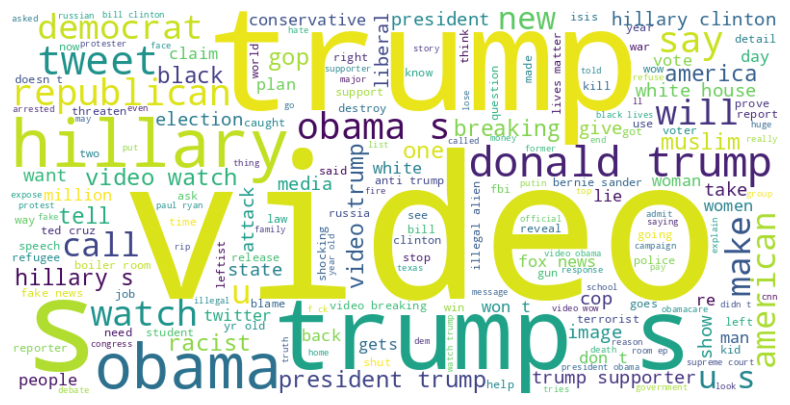

In [ ]:
# Estrazione delle parole dai titoli delle fake news
words_fake = [word.lower() for title in fake_titles for word in word_tokenize(title)]

# Creazione della nuvola di parole
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words_fake))

# Visualizzazione della nuvola di parole
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Creazione modello per identificare fake news

In [ ]:
.sample(15)

,title,text,subject,date,label
11606,horrible maxine water call trump kremlin klan ...,notice left still push false narrative russian...,politics,"Feb 22, 2017",0
19882,uk threat level remain critical minister,london reuter threat level face britain remain...,worldnews,"September 16, 2017",1
6665,kremlin say washington must prove hack accusat...,tokyo reuter kremlin say friday united states ...,politicsNews,"December 16, 2016",1
10962,texas prosecutor offer probation antiabortion ...,houston reuter antiabortion activist indict us...,politicsNews,"February 4, 2016",1
145,two word gop congressman admit answer constituent,gop congress approval donald trump put forth y...,News,"November 3, 2017",0
4574,jan brewer birther democrats country video,donald trump supporter vigorously try blame an...,News,"September 18, 2016",0
23473,astroturfe journalist reveal brainwash tactic ...,vic bishop wake timesour reality carefully con...,Middle-east,"January 19, 2016",0
8154,democratic vp nominee kaine expect release med...,washington reuters democratic vice presidentia...,politicsNews,"September 14, 2016",1
16620,lords prayer ad bannedone month later muslim g...,america push back london red bus muslim sign s...,Government News,"May 9, 2016",0
18883,campus craziness student grade go use word man...,battle mankind take place inside northern ariz...,left-news,"Apr 1, 2017",0


In [ ]:
# Preprocessing dei dati
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X = tfidf_vectorizer.fit_transform(df_full['text'])
y = df_full['label']

# Dividi i dati in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addestramento del modello SVM
svm_model = SVC(kernel='linear', C=1.0)  # Utilizziamo un kernel lineare
svm_model.fit(X_train, y_train)

## VALUTAZIONE DEL MODELLO

In [ ]:
# Valutazione del modello
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4548
           1       0.99      1.00      0.99      4306

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854



## Esportazione del Modello

Una volta soddisfatto delle prestazioni del modello, esportalo utilizzando la libreria pickle in Python.
Assicurati di includere le istruzioni necessarie per caricare e utilizzare il modello.

In [ ]:
import pickle
# Salva il modello utilizzando pickle
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

## ISTRUZIONI USO MODELLO SALVATO

Per caricare e utilizzare un modello SVM salvato con il formato pickle in Python, puoi seguire questi passaggi:

Importa le librerie necessarie:
python
Copia codice
import pickle
from sklearn import svm
Carica il modello SVM dal file pickle:
python
Copia codice
with open('nome_file_modello.pkl', 'rb') as f:
    modello_svm = pickle.load(f)
Assicurati di sostituire 'nome_file_modello.pkl' con il percorso e il nome del file in cui hai salvato il modello SVM.

Utilizza il modello per fare previsioni:
python
Copia codice
# Esempio di dati di input per la previsione
dato_di_input = [[valore_feature1, valore_feature2, ...]]

# Fai previsioni utilizzando il modello
previsione = modello_svm.predict(dato_di_input)
Con questi passaggi, hai caricato il modello SVM precedentemente salvato con pickle e hai fatto previsioni utilizzandolo con nuovi dati di input.

Ricorda di sostituire 'valore_feature1', 'valore_feature2', ... con i valori effettivi delle tue feature quando fai previsioni.